In [212]:
import pandas as pd
import numpy as np
import os
from ta.utils import dropna
import ta.trend as ta_trend
import ta.momentum as ta_mmt
import ta.others as ta_other
import ta 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tensorflow.keras.models import load_model
import joblib

from datetime import datetime,date,timedelta

In [193]:
ab_path = "../data/SPY-Daily-May23-Prediction.csv"

start_date='2023-01-01'  # First recoud 
end_date='2023-05-26'  # last record
# no bar=last record-start_date

AssetName="S&P500"

date_col='Date'
prediction_col='EMA1'
feature_cols=['EMA1']

input_sequence_length =60
output_sequence_length =10




In [194]:
print("Load model and scaler")
x_model = load_model("model/EMA1_60To10_SPY_E150S15-Y2015-2023_ma.h5")
x_scaler = joblib.load("model/scaler_EMA1_60To10_SPY_E150S15-Y2015-2023.gz")
x_scalerPred=joblib.load("model/scaler_pred_EMA1_60To10_SPY_E150S15-Y2015-2023.gz")



# x_model = load_model("model/best_tune_EMA1_60To10_SPY_E150S15-Y2015-2023.h5")
# x_scaler = joblib.load("model/scaler_best_tune_EMA1_60To10_SPY_E150S15-Y2015-2023.gz")
# x_scalerPred=joblib.load("model/scaler_pred_best_tune_EMA1_60To10_SPY_E150S15-Y2015-2023.gz")

print("Model and Scaler Object Summary")
print(x_model.summary())

#(max - min) / (X.max(axis=0) - X.min(axis=0))
print(f"max={x_scaler.data_max_} and min={x_scaler.data_min_} and scale={x_scaler.scale_}")
print(f"max={x_scalerPred.data_max_} and min={x_scalerPred.data_min_} and scale={x_scalerPred.scale_}")

Load model and scaler
Model and Scaler Object Summary
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 240)               232320    
                                                                 
 dropout_1 (Dropout)         (None, 240)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2410      
                                                                 
Total params: 234,730
Trainable params: 234,730
Non-trainable params: 0
_________________________________________________________________
None
max=[473.99] and min=[187.09] and scale=[0.00348554]
max=[473.99] and min=[187.09] and scale=[0.00348554]


D:\ProgramData\Anaconda3\envs\google_base\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Load data and Create Feature uisng Technocal Analysis Indicator

In [195]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':date_col},inplace=True)
df.drop(columns=['Ticker'],inplace=True)


df['EMA1']=ta_trend.ema_indicator(close=df['close'],window=10,fillna=True).round(4)
df['EMA2']=ta_trend.ema_indicator(close=df['close'],window=20,fillna=True).round(4)
df['MACD']=ta_trend.macd(close=df['close'], window_slow=20, window_fast=10, fillna=True).round(4)
df['SIGNAL']=ta_trend.macd_signal(close=df['close'], window_slow=20, window_fast=10,window_sign=15, fillna=True).round(4)

allCols=list(df.columns)
print(allCols)


df.set_index(date_col,inplace=True)
df=df.loc[start_date:end_date]
print(df.info())
df.tail()

df.info()
df.tail(10)

['Date', 'close', 'EMA1', 'EMA2', 'MACD', 'SIGNAL']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101 entries, 2023-01-03 to 2023-05-26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   101 non-null    float64
 1   EMA1    101 non-null    float64
 2   EMA2    101 non-null    float64
 3   MACD    101 non-null    float64
 4   SIGNAL  101 non-null    float64
dtypes: float64(5)
memory usage: 4.7 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101 entries, 2023-01-03 to 2023-05-26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   101 non-null    float64
 1   EMA1    101 non-null    float64
 2   EMA2    101 non-null    float64
 3   MACD    101 non-null    float64
 4   SIGNAL  101 non-null    float64
dtypes: float64(5)
memory usage: 4.7 KB


,close,EMA1,EMA2,MACD,SIGNAL
Date,,,,,
2023-05-15,413.01,411.7209,410.8022,0.9187,1.3008
2023-05-16,410.25,411.4535,410.7496,0.7039,1.2262
2023-05-17,415.23,412.1401,411.1763,0.9638,1.1934
2023-05-18,419.23,413.4292,411.9433,1.4859,1.2300
2023-05-19,418.62,414.3730,412.5792,1.7938,1.3005
2023-05-22,418.79,415.1761,413.1707,2.0054,1.3886
2023-05-23,414.09,414.9786,413.2582,1.7204,1.4300
2023-05-24,411.09,414.2716,413.0517,1.2198,1.4038
2023-05-25,414.65,414.3404,413.2040,1.1364,1.3704


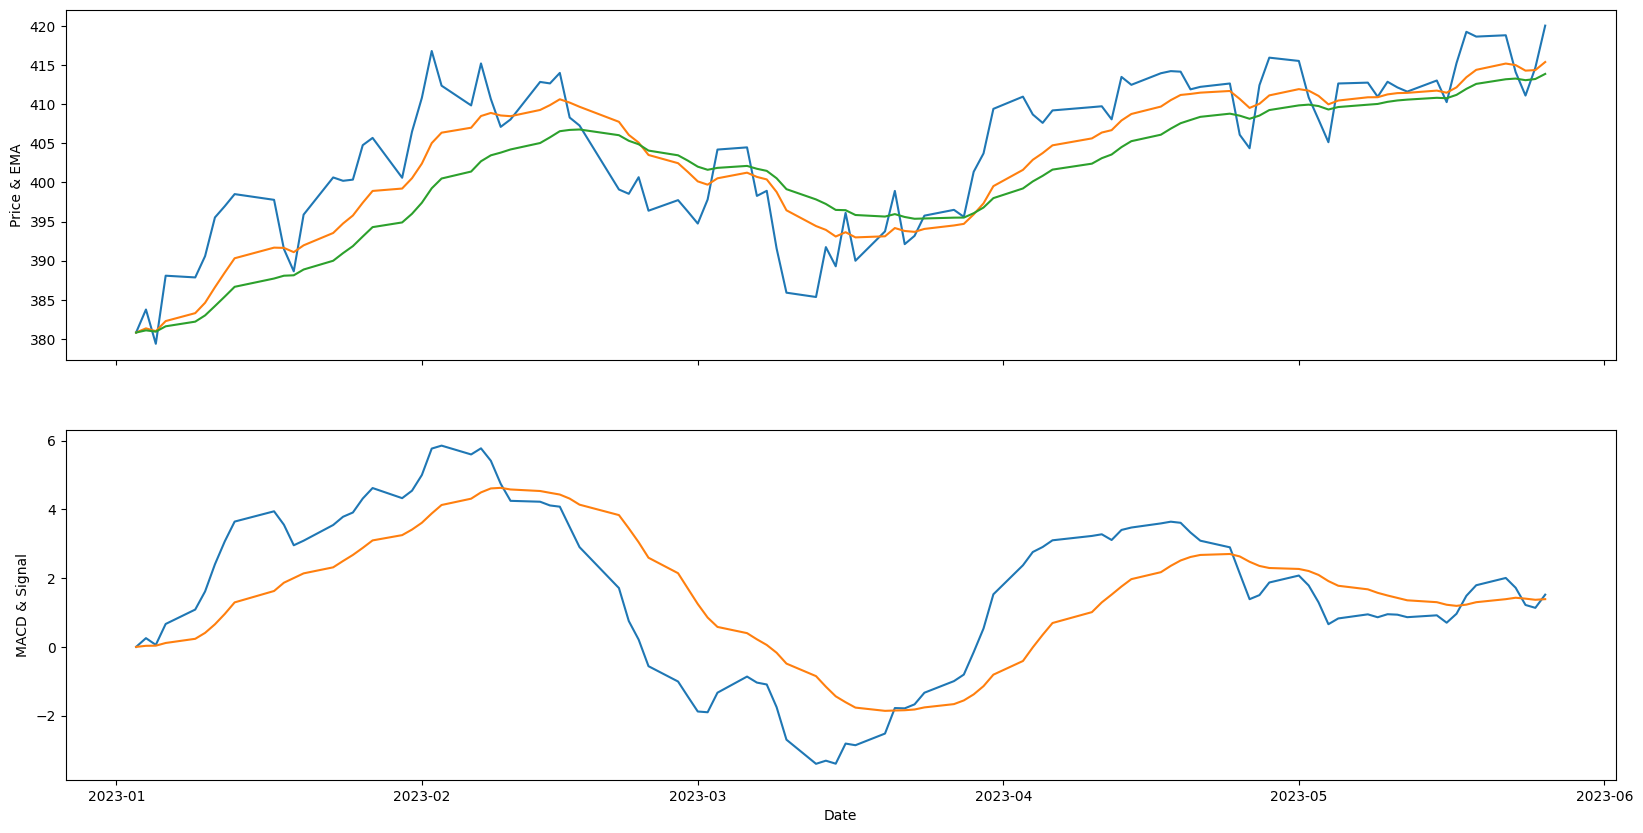

In [196]:
plt.subplots(2, 1, figsize = (20, 10),sharex=True)

ax1 = plt.subplot(2, 1, 1)
plt.plot(df[['close','EMA1','EMA2']])
plt.ylabel('Price & EMA')

ax2 = plt.subplot(2, 1, 2)
plt.plot(df[['MACD','SIGNAL']])
plt.xlabel('Date')
plt.ylabel('MACD & Signal')

plt.show()

# Get only Feature to Predict itself in the next N days

In [197]:
# get data last 60 days (select * from table limit 60) to predict tomorow at 
# 12:00 For S&P
# 08:00 For SET Thailand

dfForPred=df[feature_cols]
#dfForPred=dfForPred.iloc[-(input_sequence_length+1):-1,:]
dfForPred=dfForPred.iloc[-input_sequence_length:,:]
print(dfForPred.info())
print(dfForPred.shape)

print(dfForPred.head(5))
print(dfForPred.tail(5))


# dfForPred.plot(figsize = (20, 10))
# plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2023-03-03 to 2023-05-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EMA1    60 non-null     float64
dtypes: float64(1)
memory usage: 960.0 bytes
None
(60, 1)
                EMA1
Date                
2023-03-03  400.5214
2023-03-06  401.2393
2023-03-07  400.6995
2023-03-08  400.3759
2023-03-09  398.7730
                EMA1
Date                
2023-05-22  415.1761
2023-05-23  414.9786
2023-05-24  414.2716
2023-05-25  414.3404
2023-05-26  415.3730


In [198]:
xUnscaled=dfForPred.values #print(xUnscaled.shape)
xScaled=x_scaler.transform(xUnscaled)
print(xScaled.shape)
print(xScaled[-5:])

# # Way1
# xScaledToPredict = []
# xScaledToPredict.append(xScaled)
# print(len(xScaledToPredict))

# yPredScaled=x_model.predict(np.array(xScaledToPredict))
# print(yPredScaled.shape,yPredScaled)

# yPred  = x_scalerPred.inverse_transform(yPredScaled.reshape(-1, 1))
# print(yPred.shape,yPred)

#Way2
xScaledToPredict= xScaled.reshape(1,input_sequence_length,len(feature_cols))
print(xScaledToPredict.shape)

yPredScaled = x_model.predict(xScaledToPredict)
print(yPredScaled.shape, yPredScaled)

yPred = x_scalerPred.inverse_transform(yPredScaled).reshape(-1, 1)
print(yPred.shape, yPred)


print("============================Summary============================")
print(xUnscaled.shape)
print(yPred.shape)

# print("============================Input============================")
# print(xUnscaled)
# print("============================Output============================")
# print(yPred)



(60, 1)
[[0.79500209]
 [0.7943137 ]
 [0.79184942]
 [0.79208923]
 [0.79568839]]
(1, 60, 1)
1/1 [==============================] - 1s 1s/step
(1, 10) [[0.8057775  0.8058989  0.8000745  0.7870566  0.7920436  0.78843707
  0.77305555 0.8098116  0.79685855 0.80045265]]
(10, 1) [[418.26755]
 [418.3024 ]
 [416.63138]
 [412.89655]
 [414.3273 ]
 [413.2926 ]
 [408.87964]
 [419.42496]
 [415.70874]
 [416.73987]]
============================Summary============================
(60, 1)
(10, 1)


In [199]:
# data result
# datePredction: date  ,  dataToPredict: [date,ema1]  ,predictionResult:[value] 

,Date
0,2023-03-03
1,2023-03-06
2,2023-03-07
3,2023-03-08
4,2023-03-09
5,2023-03-10
6,2023-03-13
7,2023-03-14
8,2023-03-15
9,2023-03-16


In [230]:
colInput='feature'
colOutput='prediction'

dfFeature=pd.DataFrame(data= xUnscaled,columns=feature_cols,index=dfForPred.index)
dfFeature['Type']=colInput
# dfFeature

In [231]:
lastRowOfFeature=dfFeature.index.max()
firstRowofPrediction=lastRowOfFeature+timedelta(days=1)
datePred=pd.date_range(start=firstRowofPrediction,freq='b',periods=output_sequence_length)
print(datePred)


DatetimeIndex(['2023-05-29', '2023-05-30', '2023-05-31', '2023-06-01',
               '2023-06-02', '2023-06-05', '2023-06-06', '2023-06-07',
               '2023-06-08', '2023-06-09'],
              dtype='datetime64[ns]', freq='B')


In [232]:
dfPrediction=pd.DataFrame(data= yPred,columns=feature_cols,index=datePred)
dfPrediction['Type']=colOutput
dfPrediction

,EMA1,Type
2023-05-29,418.267548,prediction
2023-05-30,418.302399,prediction
2023-05-31,416.631378,prediction
2023-06-01,412.896545,prediction
2023-06-02,414.327301,prediction
2023-06-05,413.292603,prediction
2023-06-06,408.879639,prediction
2023-06-07,419.424957,prediction
2023-06-08,415.708740,prediction
2023-06-09,416.739868,prediction


In [233]:
dfResult=pd.concat([dfFeature,dfPrediction],ignore_index=False)
print(dfResult.info())
dfResult

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70 entries, 2023-03-03 to 2023-06-09
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EMA1    70 non-null     float64
 1   Type    70 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.6+ KB
None


,EMA1,Type
2023-03-03,400.521400,feature
2023-03-06,401.239300,feature
2023-03-07,400.699500,feature
2023-03-08,400.375900,feature
2023-03-09,398.773000,feature
...,...,...
2023-06-05,413.292603,prediction
2023-06-06,408.879639,prediction
2023-06-07,419.424957,prediction
2023-06-08,415.708740,prediction


<Axes: title={'center': 'S&P500 - 60 days ago to predict next 10 days'}, ylabel='EMA1'>

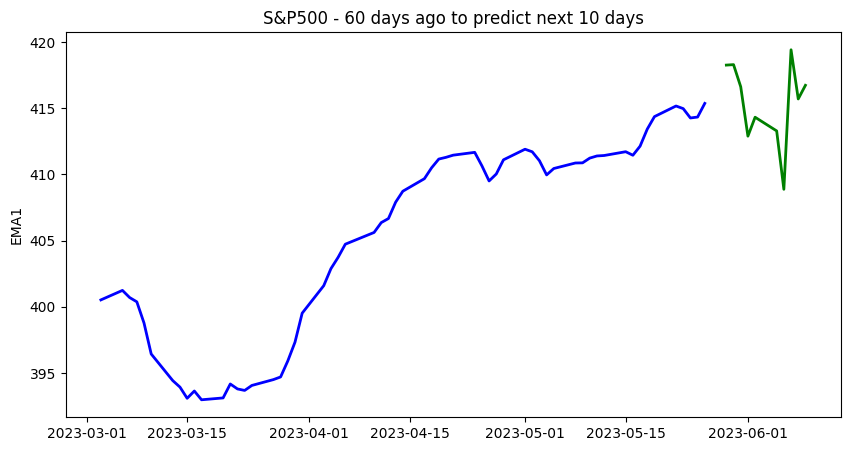

In [234]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.title(f"{AssetName} - {input_sequence_length} days ago to predict next {output_sequence_length} days", fontsize=12)
#sns.lineplot(data = dfResult[prediction_col], linewidth=4.0,  markers='o',ax=ax,color='black')
sns.lineplot(data = dfResult.query("Type==@colInput")[prediction_col], linewidth=2.0, ax=ax,color='blue')
sns.lineplot(data = dfResult.query("Type==@colOutput")[prediction_col], linewidth=2.0, ax=ax,color='green')